<a href="https://colab.research.google.com/github/steunet/steuGPT/blob/main/Sentiment_Analysis_using_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
#code for doing sentiment analysis using SST2 as dataset, BERT as tokenizer
# code taken and modified from:  Large Language Models in Depth - Mannings and https://www.kaggle.com/code/prakharrathi25/sentiment-analysis-using-bert

!pip install transformers
!pip install datasets
!pip install transformers[torch]
from datasets import load_dataset,load_metric,concatenate_datasets
from transformers import BertTokenizer, BertForMaskedLM, TrainingArguments, Trainer, BertForSequenceClassification
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt


In [2]:
#done separatelly for colab problem  https://discuss.huggingface.co/t/trainingargument/39929
!pip install accelerate -U

In [3]:
dataset = load_dataset("glue", "sst2")
dataset["pos_train"] = dataset["train"].filter(lambda x: x["label"]==1)
dataset["neg_train"] = dataset["train"].filter(lambda x: x["label"]==0)

In [4]:
# tokenize data using BERT
def tokenize_function(example):
  return tokenizer(example["sentence"], truncation=True)
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets.set_format("torch")


Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

Map:   0%|          | 0/37569 [00:00<?, ? examples/s]

Map:   0%|          | 0/29780 [00:00<?, ? examples/s]

In [5]:
print (tokenized_datasets)
#input_ids, consisting of a list of integers that map each token in the sentence to the BERT index associated with those tokens.
#token_type_ids, an array indicating whether each token is in the "question" or "answer" portion of the transformed sentence (in our case, the whole sentence questions, hence every entry is 0)
#attention_mask, an array of 1s and 0s, indicating the location of tokens to be considered while training (1s) and the location of tokens to be ignored (0).


DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1821
    })
    pos_train: Dataset({
        features: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 37569
    })
    neg_train: Dataset({
        features: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 29780
    })
})


In [6]:
# Some of the common BERT tokens
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


In [7]:
def compute_acc(eval_preds):
  # find highest confidence label
  preds = np.argmax(eval_preds.predictions, axis=-1)
  labels = eval_preds.label_ids
  # calculate percentage of correct predictions
  acc = sum([int(i==j) for i,j in zip(preds, labels)])/len(labels)
  return acc

In [8]:
#pretraini / fine loop
training_sizes = [0, 16, 32, 64, 128, 256]
history = defaultdict(list)
for k in training_sizes:
  # collect training sample of k positives and k negatives
  train_sample = concatenate_datasets([tokenized_datasets["pos_train"].select(range(k)),tokenized_datasets["neg_train"].select(range(k))])
  training_args = TrainingArguments("trainer")
  model = BertForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)
  # define training routine
  trainer = Trainer(model, training_args,
  train_dataset=train_sample, tokenizer=tokenizer)
  # do not train for zero-shot (k=0)
  if k>0: trainer.train()
  # predict labels for validation sample
  preds = trainer.predict(tokenized_datasets["validation"])
  accuracy = compute_acc(preds)
  history['k'].append(k)
  history['accuracy'].append(accuracy)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


defaultdict(<class 'list'>, {'k': [0], 'accuracy': [0.5091743119266054]})


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


defaultdict(<class 'list'>, {'k': [0, 16], 'accuracy': [0.5091743119266054, 0.6456422018348624]})


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


defaultdict(<class 'list'>, {'k': [0, 16, 32], 'accuracy': [0.5091743119266054, 0.6456422018348624, 0.6639908256880734]})


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


defaultdict(<class 'list'>, {'k': [0, 16, 32, 64], 'accuracy': [0.5091743119266054, 0.6456422018348624, 0.6639908256880734, 0.8589449541284404]})


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


defaultdict(<class 'list'>, {'k': [0, 16, 32, 64, 128], 'accuracy': [0.5091743119266054, 0.6456422018348624, 0.6639908256880734, 0.8589449541284404, 0.8440366972477065]})


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


defaultdict(<class 'list'>, {'k': [0, 16, 32, 64, 128, 256], 'accuracy': [0.5091743119266054, 0.6456422018348624, 0.6639908256880734, 0.8589449541284404, 0.8440366972477065, 0.8360091743119266]})


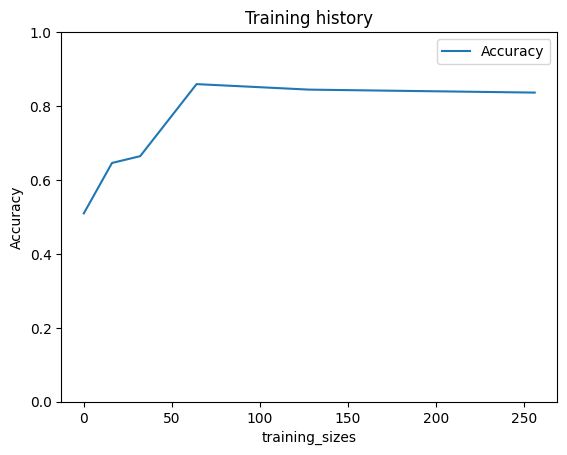

In [9]:

# Plot training and validation accuracy
plt.plot(history['k'], history['accuracy'], label='Accuracy')


# Graph chars
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('training_sizes')
plt.legend()
plt.ylim([0, 1]);